# LLB implementation with dynamical evaluation of constants

In this attempt, I will set up the simulation to only precalulate and interpolate the temperature map and mean field magnetization. All other temperature dependent paramters will be evaluated dynamically from the interpolated temperatures and mean field amgnetizations. To determin the under/obver T_c behavoiur at each timestep and in each grain we precondruct a boolean-array-map saving only under/over tc. To read this information out at desired timesteps we use finderb 

## Import packages

In [1]:
import numpy as np
from scipy import constants as sp
from scipy import optimize as op
from scipy import interpolate as ip
from matplotlib import pyplot as plt
import itertools
import time
from scipy.integrate import solve_ivp

## Define finderb

Just as used in udkm1dsim. Is used here only to find the proper timestep to select over/under Tc behaviour.

In [2]:
def finderb(key, array):
    """finderb

    Binary search algorithm for sorted array. Searches for the first index
    ``i`` of array where ``key`` >= ``array[i]``. ``key`` can be a scalar or
    a np.ndarray of keys. ``array`` must be a sorted np.ndarray.

    Author: André Bojahr.
    Licence: BSD.

    Args:
        key (float, ndarray[float]): single or multiple sorted keys.
        array (ndarray[float]): sorted array.

    Returns:
        i (ndarray[float]): position indices for each key in the array.

    """
    key = np.array(key, ndmin=1)
    n = len(key)
    i = np.zeros([n], dtype=int)

    for m in range(n):
        i[m] = finderb_nest(key[m], array)
    return i

In [3]:
def finderb_nest(key, array):
    """finderb_nest

    Nested sub-function of :func:`.finderb` for one single key.

    Author: André Bojahr.
    Licence: BSD.

    Args:
        key (float): single key.
        array (ndarray[float]): sorted array.

    Returns:
        a (float): position index of key in the array.

    """
    a = 0  # start of intervall
    b = len(array)  # end of intervall

    # if the key is smaller than the first element of the
    # vector we return 1
    if key < array[0]:
        return 0

    while (b-a) > 1:  # loop until the intervall is larger than 1
        c = int(np.floor((a+b)/2))  # center of intervall
        if key < array[c]:
            # the key is in the left half-intervall
            b = c
        else:
            # the key is in the right half-intervall
            a = c

    return a

## Define material class

In [4]:
class material():
    def __init__(self, name, S, Tc, lamda, muat, kappa_anis, anis_axis, K_0, A_0, Ms, Delta):
        self.name=name                                      # name of the material used for the string representation of the class
        self.S=S                                            # effective spin
        self.Tc=Tc                                          # Curie temperature
        self.J=3*self.S/(self.S+1)*sp.k*self.Tc             # mean field exchange coupling constant
        self.mean_mag_map=self.create_mean_mag_map()         # creates the mean magnetization map over temperature as an interpolation function
        self.lamda=lamda                                    # intrinsic coupling to bath parameter
        self.muat=muat                                      # atomic magnetic moment in units of mu_Bohr
        self.kappa_anis=kappa_anis                          # exponent for the temperature dependence of uniaxial anisotropy
        self.anis_axis=anis_axis                            # uniaxials anisotropy axis (x:0, y:1, z:2) other anisotropies are not yet implemented 
        self.K_0=K_0                                        # value for the anisotropy at T=0 K in units of J/m^3
        self.A_0=A_0                                        # value for the exchange stiffness at T=0 K in units of J/m
        self.Ms=Ms                                          # value for the saturation magnetization at 0K in J/T/m^3
        self.Delta=Delta                                    # length of the grain in depth direction in m
        
    def __str__(self):
        return self.name
    
    def create_mean_mag_map(self):
        # This function computes the mean field mean magnetization map by solving the self-consistent equation m=B(m, T)
        # As an output we get an interpolation function of the mean field magnetization at any temperature T<=T_c (this can of course be extended to T>T_c with zeros).

        # Start by defining a unity function m=m:
        def mag(m):
            return m

        # Define the Brillouin function as a function of scalars, as fsolve takes functions of scalars:
        def Brillouin(m, T):
            # This function takes input parameters
            #   (i) magnetization amplitude m_amp_grid (scalar)
            #   (ii) (electron) temperature (scalar)
            # As an output we get the Brillouin function evaluated at (i), (ii) (scalar)

            eta = self.J * m / sp.k / T /self.Tc
            c1 = (2 * self.S + 1) / (2 * self.S)
            c2 = 1 / (2 * self.S)
            bri_func = c1 / np.tanh(c1 * eta) - c2 / np.tanh(c2 * eta)
            return bri_func

        # Then we also need a temperature grid. I'll make it course grained for low temperatures (<0.8*Tc) (small slope) and fine grained for large temperatures (large slope):
        temp_grid=np.array(list(np.arange(0, 0.8, 1e-3))+list(np.arange(0.8, 1+1e-5, 1e-5)))

        # I will define the list of m_eq(T) here and append the solutions of m=B(m, T). It will have the length len(temp_grid) at the end.
        meq_list=[1.]

        # Define a function to find the intersection of m and B(m, T) for given T with scipy:
        def find_intersection_sp(m, Bm, m0):
            return op.fsolve(lambda x: m(x) - Bm(x), m0)

        # Find meq for every temperature, starting point for the search being (1-T/Tc)^(1/2), fill the list
        for i,T in enumerate(temp_grid[1:]):
            # Redefine the Brillouin function to set the temperature parameter (I did not find a more elegant solution to this):
            def Brillouin_2(m):
                return Brillouin(m, T)
            # Get meq:
            meq=find_intersection_sp(mag, Brillouin_2, np.sqrt(1-T))
            if meq[0]<0:            # This is a comletely unwarranted fix for values of meq<0 at temperatures very close to Tc, that fsolve produces. It seems to work though, as the interpolated function plotted by plot_mean_mags() seems clean.
                meq[0]*=-1
            # Append it to list me(T)
            meq_list.append(meq[0])
        meq_list[-1]=0              # This fixes slight computational errors to fix m_eq(Tc)=0 (it produces something like m_eq[-1]=1e-7)
        return ip.interp1d(temp_grid, meq_list)
    
    def dbrillouin_t1(self):
        return 1/4/self.S**2
    
    def dbrillouin_t2(self):
        return (2*self.S+1)**2/4/self.S**2
    
    def get_mean_mag(self, T, tc_mask):
        # After creating the map, this function can be called to give m_eq at any temperature
        # The function takes a 1d-array of temperatures as an input (temperature map at each timestep) and returns an array with the respective mean field equilibrium magnetization
        meq=np.zeros(T.shape)
        meq[tc_mask]=self.mean_mag_map(T[tc_mask])
        return meq
    
    def alpha_par(self):
        # This funtion computes the longitudinal damping parameter alpha_parallel
        return 2*self.lamda/(self.S+1)

    def qs(self):
        # This function computes the first term of the transverse damping parameter alpha_transverse
        qs=3*self.Tc/(2*self.S+1)
        return qs
    
    def chi_par_num(self):
        return 1/sp.k*self.muat*9.274e-24
    
    def chi_par_denomm1(self):
        return self.J/sp.k
    
    def anisotropy(self):
        #This takes mean field magnetization (1d-array of length N (number of grains)), magnetization vectors (dimension 3xN), magnetization amplitudes (length N) and easy axis ([0,1,2] corresponding to [x,y,z])
        return -2*self.K_0

## Create a sample structure

In [5]:
def get_sample():
    # This is a dummy function that should definitely be replaced by outputs from your code. It does not take any input parameters as I define everything here.
    # As an output we get
    #   (i) a 1d list of M materials within the sample (materials on the scale of the grainsize of the macrospins)
    #   (ii) a 1d numpy array of the actual sample consisting of stacked layers of the M materials
    #   (iii-v) magnetization amplitudes and angles
    
    # Define define three dummy materials with different parameters:
    mat_1 = material('Nickel', 0.5, 630., 0.005, 0.393, 3, 2,  0.45e6, -1e-11, 500e3, 1e-9)
    mat_2 = material('Cobalt', 1e6, 1480., 0.1, 0.393, 3, 2, 0.45e6, -1e-11*0., 1400e3, 1e-9)
    mat_3 = material('Iron', 2., 1024., 0.005, 2.2, 3, 2, 0.45e6, -1e-11, 200e3, 1e-9)
    #FGT = material ('FGT', 0.5, 220., 0.01, 2.2, 3, 2, 0.45e6, 1e-11, 200e-13, 1e-9)
    #FGT2 = material ('FGT2', 2., 220., 0.01, 2.2, 3, 2, 0.45e6, 1e-11, 200e-13, 1e-9)
    
    materials=[mat_2]
    
    Nickel_1=[mat_1 for _ in range(10)]
    Cobalt=[mat_2 for _ in range(15)]
    Iron=[mat_3 for _ in range(10)]
    Nickel_2=[mat_1 for _ in range(25)]
    
    sample=np.array(Cobalt)
    
    #The following constructs a list of lists, containing in list[i] a list of indices of material i in the sample_structure. This will help compute the mean field magnetization only once for every material at each timestep. 
    material_grain_indices=[]
    for mat in materials:
        material_grain_indices.append([i for i in range(len(sample)) if sample[i]==mat])
    material_grain_indices_flat=[index for mat_list in material_grain_indices for index in mat_list]
    sample_sorter=np.array([material_grain_indices_flat.index(i) for i in np.arange(len(sample))])
    
    #The following list locates which material is positioned at which grain of the sample. THis will later be used to define an array of material paramters for the whole sample 
    mat_locator=[materials.index(grain) for grain in sample]

    #Define initial magnetization on the whole sample (for simplicity uniform) and fully magnetized along the z-axis
    m_amp = np.ones(len(sample))
    m_phi = np.zeros(len(sample))
    m_gamma = np.zeros(len(sample))
    return materials, sample, m_amp, m_phi, m_gamma, material_grain_indices, sample_sorter, mat_locator

In [6]:
def plot_mean_mags(materials):
    #define a temperature grid:
    temps=np.arange(0,2+1e-4, 1e-4)
    tc_mask=temps<1.
    temps[-1]=1.
    for i,m in enumerate(materials):
        mmag=get_mean_mag(m, temps, tc_mask)
        label=str(m.name)
        plt.plot(temps*m.Tc, mmag, label=label)

    plt.xlabel(r'Temperature [K]', fontsize=16)
    plt.ylabel(r'$m_{\rm{eq}}$', fontsize=16)
    plt.legend(fontsize=14)
    plt.title(r'$m_{\rm{eq}}$ for all materials in sample', fontsize=18)
    plt.savefig('plots/meqtest.pdf')
    plt.show()

## Define parameters on sample structure

In [7]:
def get_ex_stiff_sample(materials, sample, mat_loc, Ms_sam, Delta2_sam):
    #This computes a grid for the exchange stiffness in analogous fashion to get_exch_coup_sam()
    A_mat=np.zeros((len(materials), len(materials)))
    for i, mat in enumerate(materials):
        A_mat[i][i]=mat.A_0
        
    #A_mat[0][1]=-1e-11
    #A_mat[1][2]=-5e-11
    #A_mat[0][2]=-2.5e-11
    
    for i in range(1, len(materials)):
        for j in range(i):
            A_mat[i][j]=A_mat[j][i]
            
    ex_stiff_arr=np.ones((len(sample),2))*A_mat[0][0]
    
    for i, grain in enumerate(sample):
        if i>0:
            ex_stiff_arr[i][0]=A_mat[mat_loc[i]][mat_loc[i-1]]
        if i<len(sample)-1:
            ex_stiff_arr[i][1]=A_mat[mat_loc[i]][mat_loc[i+1]]
    return np.divide(ex_stiff_arr, np.multiply(Ms_sam, Delta2_sam)[:,np.newaxis])

In [8]:
def S_sample(sample):
    return np.array([mat.S for mat in sample])

In [9]:
def Tc_sample(sample):
    return np.array([mat.Tc for mat in sample])

In [10]:
def J_sample(sample):
    return np.array([mat.J for mat in sample])

In [11]:
def lamda_sample(sample):
    return np.array([mat.lamda for mat in sample])

In [12]:
def muat_sample(sample):
    return np.array([mat.muat for mat in sample])

In [13]:
def Ms_sample(sample):
    return np.array([mat.Ms for mat in sample])

In [14]:
def Delta2_sample(sample):
    return np.array([mat.Delta**2 for mat in sample])

In [15]:
def get_ani_sample(sample, Ms_sam):
    ani_sam=np.divide(np.array([mat.anisotropy() for mat in sample]), Ms_sam)
    kappa_ani_sam=np.array([mat.kappa_anis for mat in sample])
    ani_perp_sam= np.ones((len(sample), 3))
    for i,mat in enumerate(sample):
        ani_perp_sam[i, mat.anis_axis]=0
    return ani_sam, kappa_ani_sam, ani_perp_sam

In [16]:
def alpha_par_sample(sample):
    return np.array([mat.alpha_par() for mat in sample])

In [17]:
def qs_sample(sample):
    return np.array([mat.qs() for mat in sample])

In [18]:
def dbrillouin_t1_sample(sample):
    return np.array([mat.dbrillouin_t1() for mat in sample])

def dbrillouin_t2_sample(sample):
    return np.array([mat.dbrillouin_t2() for mat in sample])

In [19]:
def chi_par_num_sample(sample):
    return np.array([mat.chi_par_num() for mat in sample])

def chi_par_denomm1_sample(sample):
    return np.array([mat.chi_par_denomm1() for mat in sample])

## Functions to import temperature map and create corresponding mean_mag_map

In [20]:
def get_tes():
    delay=np.load('temp_test/delays.npy')
    teNi1=np.load('temp_test/tesNickel0.npy')
    teCo2=np.load('temp_test/tesCobalt1.npy')
    teFe3=np.load('temp_test/tesIron2.npy')
    teNi4=np.load('temp_test/tesNickel3.npy')
    tes=np.append(teNi1, teCo2, axis=1)
    tes=np.append(tes, teFe3, axis=1)
    tes=np.append(tes, teNi4, axis=1)
    tes=teCo2
    return delay, tes

In [21]:
def get_tc_mask(te_red, Tc_sam):
    under_tc=te_red<1.
    return under_tc

In [22]:
def get_mean_mag_sample_Ts(te_red, under_tc, mat_gr_ind, mat_gr_ind_flat, materials):
    mmag_sam_T=[[materials[i].get_mean_mag(te_red[:,j], under_tc[:,j]) for j in mat_gr_ind[i]] for i in range(len(mat_gr_ind))]
    mmag_sam_T_flat=np.concatenate(mmag_sam_T)[mat_gr_ind_flat]
    return mmag_sam_T_flat

## Transform initial polar magnetization input into cartesian coordinates

In [23]:
def get_mag(polar_dat):
    # This function takes as input parameters the amplitude and angles (A, gamma, phi) and puts out a numpy array of dimension 3xlen(sample)
    # with 3 magnetization components for len(sample) grains
    amp=polar_dat[0,:]
    gamma=polar_dat[1,:]
    phi=polar_dat[2,:]
    sin_phi=np.sin(phi)
    
    mx=amp*sin_phi*np.cos(gamma)
    my=amp*sin_phi*np.sin(gamma)
    mz=amp*np.cos(phi)
    
    return np.array([mx,my,mz]).T

## Setup of temperature dynamic parameters

In [24]:
def ani_sample_T(mmag_sam_T, K0_sam, kappa_ani_sam):
    return np.multiply(K0_sam,np.power(mmag_sam_T,kappa_ani_sam-2))

In [25]:
def ex_stiff_sample_T(mmag_sam_T, ex_stiff_sam):
    return np.multiply(np.power(mmag_sam_T[:, np.newaxis],2-2),ex_stiff_sam)

In [26]:
def qs_sample_T(qs_sam, mmag_sam_T, T):
    return qs_sam*mmag_sam_T/T

In [27]:
def alpha_par_sample_T(mmag_sam_T, T, alpha_par_sam, qs_sam_T, Tc_sam, under_tc, over_tc, lambda_sam):
    apsT=np.zeros(len(T))
    apsT[under_tc]=alpha_par_sam[under_tc]/np.sinh(2*qs_sam_T[under_tc])
    apsT[over_tc]=lambda_sam[over_tc]*2/3*np.divide(T[over_tc], Tc_sam[over_tc])
    return apsT

In [28]:
def alpha_trans_sample_T(mmag_sam_T, lamda_sam, T, qs_sam_T, Tc_sam, under_tc, over_tc, lambda_sam):
    atsT=np.zeros(len(T))
    atsT[under_tc]=np.multiply(lambda_sam[under_tc], (np.divide(np.tanh(qs_sam_T[under_tc]), qs_sam_T[under_tc])-np.divide(T[under_tc],3*Tc_sam[under_tc])))
    atsT[over_tc]=lambda_sam[over_tc]*2/3*np.divide(T[over_tc], Tc_sam[over_tc])
    return atsT

In [29]:
def eta_sample_T(mmag_sam_T, J_sam, T):
    return J_sam*mmag_sam_T/sp.k/T

def dbrillouin_sample_T(eta_sam_T, S_sam, dbrillouin_t1_sam, dbrillouin_t2_sam):
    two_S_sam=2*S_sam
    x1=np.divide(eta_sam_T,two_S_sam)
    x2=np.divide(np.multiply(eta_sam_T,(two_S_sam+1)),two_S_sam)
    sinh_func=1/np.sinh(np.array([x1,x2]))**2
    dbrillouin_sam_T=dbrillouin_t1_sam*sinh_func[0]-dbrillouin_t2_sam*sinh_func[1]
    return dbrillouin_sam_T

def chi_par_sample_T(chi_par_num_sam, chi_par_denomm1_sam, dbrillouin_sam_T, T, under_tc, over_tc, muat_sam, Tc_sam, J_sam):
    cpsT=np.zeros(len(T))
    cpsT[under_tc]=np.multiply(chi_par_num_sam[under_tc], np.divide(dbrillouin_sam_T, T[under_tc]-np.multiply(chi_par_denomm1_sam[under_tc], dbrillouin_sam_T)))
    cpsT[over_tc]=np.divide(np.multiply(muat_sam[over_tc]*9.274e-24, Tc_sam[over_tc]), J_sam[over_tc]*(T[over_tc]-Tc_sam[over_tc]+1e-1))
    return cpsT

## Components of effective field (magnetization dependent)

In [30]:
def anis_field(anis_sam_T, m, ani_perp_sam):
    return anis_sam_T[:, np.newaxis]*(m*ani_perp_sam)

In [31]:
def ex_field(ex_stiff_sam_T, m_diff_up, m_diff_down):
    return ex_stiff_sam_T[:,0][:,np.newaxis]*m_diff_up+ex_stiff_sam_T[:,1][:,np.newaxis]*m_diff_down

In [32]:
def th_field(m, m_squared, mmag_sam_T, T, Tc_sam, chi_par_sam_T, under_tc, over_tc):
    factor = 1/chi_par_sam_T
    H_th = np.zeros(len(T))
    H_th[under_tc] = (1-m_squared[under_tc]/mmag_sam_T[under_tc]**2)*factor[under_tc]/2
    H_th[over_tc] = -(1+3/5*Tc_sam[over_tc]/(T[over_tc]-Tc_sam[over_tc]+1e-1))*m_squared[over_tc]*factor[over_tc]
    return H_th[:, np.newaxis]*m  

## Main function

In [33]:
def integrate_LLB():
    starttime=time.time()
    gamma=1.76e11 # gyromagnetic ratio in (Ts)^{-1}

    # import temperature map
    times, tes=get_tes()
    N=len(times)
    
    # load a sample and call the functions to get all parameters on the sample structure:
    materials, sample, m_amp, m_phi, m_gamma, mat_gr_ind, mat_gr_ind_flat, mat_loc=get_sample()
    
    H_ext=np.array([[0,0,0] for _ in sample]) #external field in T
    
    
    # load initial magnetization
    m0=get_mag(np.array([m_amp, m_phi, m_gamma])).flatten()
    
    # Create static parameters on sample structure
    Ms_sam=Ms_sample(sample)
    Delta2_sam=Delta2_sample(sample)
    S_sam=S_sample(sample)
    Tc_sam=Tc_sample(sample)
    J_sam=J_sample(sample)
    lamda_sam=lamda_sample(sample)
    muat_sam=muat_sample(sample)
    ex_stiff_sam=get_ex_stiff_sample(materials, sample, mat_loc, Ms_sam, Delta2_sam)
    K0_sam, kappa_ani_sam, ani_perp_sam=get_ani_sample(sample, Ms_sam)
    alpha_par_sam=alpha_par_sample(sample)
    qs_sam=qs_sample(sample)
    dbrillouin_t1_sam=dbrillouin_t1_sample(sample)
    dbrillouin_t2_sam=dbrillouin_t2_sample(sample)
    chi_par_num_sam=chi_par_num_sample(sample)
    chi_par_denomm1_sam=chi_par_denomm1_sample(sample)
    
    # create boolean array seperating temperature values under and over the respective Curie temperatures of materials in the sample:
    Te_red=np.divide(tes, Tc_sam)
    utc=get_tc_mask(Te_red, Tc_sam)
    otc=~utc

    # create the mean magnetization map for the imported temperature map:
    mms=get_mean_mag_sample_Ts(Te_red, utc, mat_gr_ind, mat_gr_ind_flat, materials)
    
    # timecheck incoming
    inichecktime=time.time()
    initime=inichecktime-starttime
    print('Time used to import temperature map and initialize mean mag map and set up static parameters on sample strucure:' , str(initime) , 's')
    
    # define and call interpolation functions for temperature map and mean_magnetization
    def mean_mag_interpol(t):
        return ip.interp1d(t,mms)
    
    def te_map(t):
        return ip.interp1d(t, tes.T)
    
    mmag_ipl=mean_mag_interpol(times)
    tes_ipl=te_map(times)
    
    #another timecheck
    inichecktime2=time.time()
    ini2time=inichecktime2-inichecktime
    print('Creation of interpolation functions of (implicitly) time dependent parameters took' , str(ini2time), 's')
    
    def LLB(t, m_flat, mmag_ipl, tes_ipl):
        
        mmag_sam_T=mmag_ipl(t)
        Te=tes_ipl(t)
        
        # find the closest timestep and select the corresponding boolean array for Tc_selection
        t_index=finderb(t, times)[0]
        under_tc=utc[t_index, :]
        over_tc=~under_tc
        
        # unflatten the magnetization input and compute squares and
        m=m_flat.reshape(len(sample), 3)
        m_squared=np.sum(np.power(m,2), axis=-1)
        m_diff_down=np.concatenate((np.diff(m, axis=0), np.zeros((1, 3))), axis=0)
        m_diff_up=-np.roll(m_diff_down, 1)
        
        # evaluate the temperature dependence of parameters
        anis_sam_T=ani_sample_T(mmag_sam_T, K0_sam, kappa_ani_sam)
        ex_stiff_sam_T=ex_stiff_sample_T(mmag_sam_T, ex_stiff_sam)
        qs_sam_T=qs_sample_T(qs_sam, mmag_sam_T, Te)
        eta_sam_T=eta_sample_T(mmag_sam_T, J_sam, Te)
        dbrillouin_sam_T=dbrillouin_sample_T(eta_sam_T[under_tc], S_sam[under_tc], dbrillouin_t1_sam[under_tc], dbrillouin_t2_sam[under_tc])
        chi_par_sam_T=chi_par_sample_T(chi_par_num_sam, chi_par_denomm1_sam, dbrillouin_sam_T, Te, under_tc, over_tc, muat_sam, Tc_sam, J_sam)


        # and the effective field
        H_ex=ex_field(ex_stiff_sam_T, m_diff_up, m_diff_down)
        H_ani=anis_field(anis_sam_T, m, ani_perp_sam)
        H_th=th_field(m, m_squared, mmag_sam_T, Te, Tc_sam, chi_par_sam_T, under_tc, over_tc)

        H_eff=H_ani+H_ex+H_th+H_ext

        # only missing the damping parameters:
        alpha_par_sam_T=alpha_par_sample_T(mmag_sam_T, Te, alpha_par_sam, qs_sam_T, Tc_sam, under_tc, over_tc, lamda_sam)
        alpha_trans_sam_T=alpha_trans_sample_T(mmag_sam_T, lamda_sam, Te, qs_sam_T, Tc_sam, under_tc, over_tc, lamda_sam)

        # we will precompute the prefactors that are not of dimension len(sample)x3:

        pref_trans=np.divide(alpha_trans_sam_T, m_squared)
        pref_long=np.multiply(np.divide(alpha_par_sam_T, m_squared),np.einsum('ij,ij->i', m, H_eff))

        # and all the cross products:
        m_rot=np.cross(m,H_eff) #precessional term
        m_trans=np.cross(m,m_rot) #transverse damping term

        trans_damp= np.multiply(pref_trans[:,np.newaxis],m_trans)
        long_damp= np.multiply(pref_long[:,np.newaxis], m)

        # Now compute the magnetization increment
        dm_dt=gamma*(-m_rot -trans_damp + long_damp)
        return dm_dt.flatten()
    
    #Now call the solver with arguments of function, initial condition, time-array and parameterlist (the gathering of interpolation functions)
    solved_LLB=solve_ivp(fun=lambda t,m: LLB(t, m, mmag_ipl, tes_ipl), t_span=(0,times[-1]), y0=m0, method='RK45')
    
    
    #last timecheck
    endtime=time.time()
    dyntime=endtime-inichecktime
    alltime=endtime-starttime
    print('Dynamical calculation took' , str(dyntime) , 's')
    print('The whole simulation took' , str(alltime), 's')
    
    #this is the mag map output:
    return solved_LLB

In [34]:
mag_map=integrate_LLB()

C:\Users\Theodor Griepe\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Time used to import temperature map and initialize mean mag map and set up static parameters on sample strucure: 11.612744569778442 s
Creation of interpolation functions of (implicitly) time dependent parameters took 0.14761686325073242 s
Dynamical calculation took 15.789095163345337 s
The whole simulation took 27.40183973312378 s


In [35]:
sim_delay=mag_map.t
mm_rs=mag_map.y.T.flatten().reshape(len(mag_map.t), 15,3)

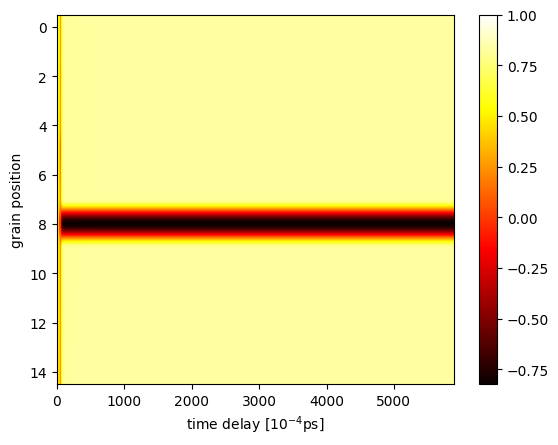

In [36]:
color_data = mm_rs[:, :, 2].T
plt.imshow(color_data, cmap='hot', aspect='auto')
plt.ylabel(r'grain position')
plt.xlabel(r'time delay [$10^{-4}$ps]')
plt.colorbar()
plt.show()

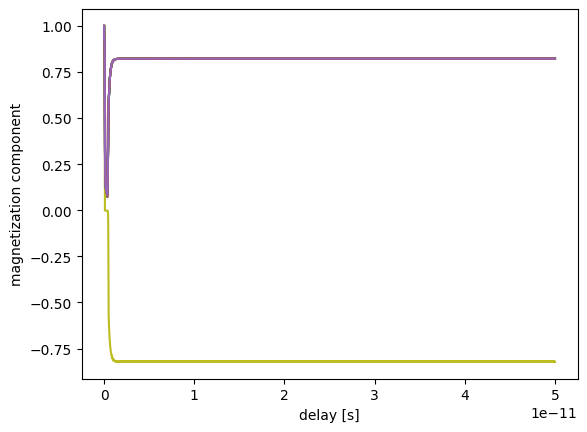

In [37]:
#plt.plot(delay, mag_map_man[:,:,2][:-1])
#plt.scatter(delay, mys)

plt.plot(sim_delay, mm_rs[:,:,2])
plt.xlabel(r'delay [s]')
plt.ylabel(r'magnetization component')

#plt.plot(new_delay, mag_map_man[:,0,0][:-1])
#plt.scatter(delay, mxs)

plt.show()

In [38]:
t, te= get_tes()

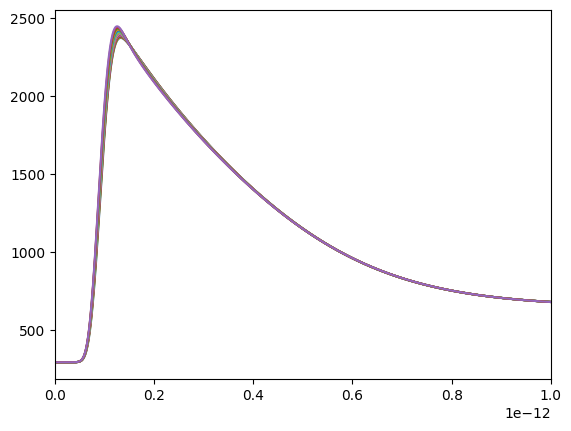

In [39]:
plt.plot(t, te)
plt.xlim(0,1e-12)
plt.show()